#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import CSVLogger, Callback
import keras.backend as K
import os

Defining a function that splits images and labels and one-hot-encodes the labels

In [2]:
# Get current working directory
cwd = pathlib.Path.cwd()

In [3]:
# Load data from cwd
ds1, ds2, ds3 = tfds.load('patch_camelyon', split=['train[:30%]', 'test[:7%]', 'validation[:7%]'], #-----------------------------
                                data_dir=cwd, 
                                download=False, 
                                shuffle_files=True)

In [4]:
#num_classes = 2  # Assuming you have two classes: cancer and non-cancer

## Function to count the labels
#def count_labels(dataset):
    #counts = [0] * num_classes
    #for _, label in dataset:  # Adjusted to unpack the correct structure
    #    label = label.numpy()  # Convert the label tensor to a numpy array
    #    counts[np.argmax(label)] += 1
    #return counts

# Since the dataset is batched, unbatch it first to count each instance separately
#autoencoder_train_dataset_unbatched = autoencoder_train_dataset.unbatch()

# Count labels in the unbatched training dataset
#label_counts = count_labels(autoencoder_train_dataset_unbatched)

# Plotting
#colors = ["skyblue", "salmon"]  # Assign colors for each class
#plt.bar(range(num_classes), label_counts, color=colors)
#plt.xlabel('Class')
#plt.ylabel


In [5]:
batch_size = 32

# For the autoencoder
def preprocess_for_autoencoder(sample):
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    return image, image  # return image as both input and target

autoencoder_train_dataset = ds1.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_validation_dataset = ds2.map(preprocess_for_autoencoder).batch(batch_size)
autoencoder_test_dataset = ds3.map(preprocess_for_autoencoder).batch(batch_size)

Next, getting ready for training by splitting it into batches.

## 1.2
Build and train autoencoders that efficiently compress the 96x96pxs color images (as a minimum train one AE model and one VAE model)

In [6]:
encoder = tf.keras.models.Sequential([
     tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
     tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=1),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', strides=2),  # Half-size reduction
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU()
 ], name='encoder')

#encoder = tf.keras.models.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(96, 96, 3)),
 #   tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
  #  tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.LeakyReLU(),
    #tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', strides=2)
#], name='encoder')


print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0   

In [7]:
decoder = tf.keras.models.Sequential([
     tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(48, 48, 32)),  # Upsampling to match the encoder
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=1),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(),
     tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')  # Output layer to match original input size
 ], name='decoder')

#decoder = tf.keras.models.Sequential([
 #   tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(24, 24, 32)),
  #  tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.LeakyReLU(),
   # tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
   # tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
#], name='decoder')


print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 96, 96, 32)       9248      
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 96, 96, 16)       4624      
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 96, 96, 16)       64        
 hNormalization)                                           

In [8]:
#from tensorflow.keras.utils import plot_model

# Assuming 'encoder' and 'decoder' are your model instances
#plot_model(encoder, to_file='encoder_architecture.png', show_shapes=True, show_layer_names=True)
#plot_model(decoder, to_file='decoder_architecture.png', show_shapes=True, show_layer_names=True)


### Autoencoder

In [9]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

# Your learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an Adam optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the autoencoder with the custom optimizer
autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])


In [10]:
#autoencoder.summary()

In [11]:
# Fit the model on the data and the labels
epochs_autoencoder = 55

class SaveBestEncoder(Callback):
    def __init__(self, encoder, filepath, monitor='val_loss', mode='min'):
        super(SaveBestEncoder, self).__init__()
        self.encoder = encoder
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get(self.monitor)
        if self.mode == 'min' and current_val < self.best:
            self.best = current_val
            self.encoder.save(self.filepath)
        elif self.mode == 'max' and current_val > self.best:
            self.best = current_val
            self.encoder.save(self.filepath)

# Usage in training
save_best_encoder_callback = SaveBestEncoder(encoder, 'ae_best_encoder.h5')

# Create CSVLogger callback to save history
csv_filepath = 'ae_training_log.csv'
csv_logger = CSVLogger(csv_filepath, append=True)

history = autoencoder.fit(
    autoencoder_train_dataset,
    validation_data=autoencoder_validation_dataset,
    verbose=1,
    epochs=epochs_autoencoder,
    callbacks=[save_best_encoder_callback, csv_logger]  # Add custom callback here
)


Epoch 1/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.6710WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 447s 182ms/step - loss: 0.0115 - accuracy: 0.6710 - val_loss: 0.0025 - val_accuracy: 0.8095
Epoch 2/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.8266WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 451s 183ms/step - loss: 0.0022 - accuracy: 0.8266 - val_loss: 0.0013 - val_accuracy: 0.8685
Epoch 3/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.8565WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 451s 183ms/step - loss: 0.0016 - accuracy: 0.8565 - val_loss: 8.9993e-04 - val_accuracy: 0.8865
Epoch 4/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.8659WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 447s 182ms/step - loss: 0.0013 - accuracy: 0.8659 - val_loss: 7.4620e-04 - val_accuracy: 0.8910
Epoch 5/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.8702WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 448s 182ms/step - loss: 0.0012 - accuracy: 0.8702 - val_loss: 6.8081e-04 - val_accuracy: 0.8964
Epoch 6/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.8720WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 0.0011 - accuracy: 0.8720 - val_loss: 6.3687e-04 - val_accuracy: 0.8967
Epoch 7/55
2458/2458 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.8734WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 447s 182ms/step - loss: 0.0010 - accuracy: 0.8734 - val_loss: 5.5238e-04 - val_accuracy: 0.8883
Epoch 8/55
2458/2458 [==============================] - ETA: 0s - loss: 9.4227e-04 - accuracy: 0.8729WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 9.4227e-04 - accuracy: 0.8729 - val_loss: 4.8713e-04 - val_accuracy: 0.8982
Epoch 9/55
2458/2458 [==============================] - ETA: 0s - loss: 9.0098e-04 - accuracy: 0.8721WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 181ms/step - loss: 9.0098e-04 - accuracy: 0.8721 - val_loss: 4.6768e-04 - val_accuracy: 0.8967
Epoch 10/55
2458/2458 [==============================] - 446s 181ms/step - loss: 8.4256e-04 - accuracy: 0.8719 - val_loss: 6.5745e-04 - val_accuracy: 0.8934
Epoch 11/55
2458/2458 [==============================] - ETA: 0s - loss: 7.9119e-04 - accuracy: 0.8715WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 447s 182ms/step - loss: 7.9119e-04 - accuracy: 0.8715 - val_loss: 4.3477e-04 - val_accuracy: 0.8823
Epoch 12/55
2458/2458 [==============================] - 446s 182ms/step - loss: 7.4843e-04 - accuracy: 0.8719 - val_loss: 4.3925e-04 - val_accuracy: 0.8834
Epoch 13/55
2458/2458 [==============================] - ETA: 0s - loss: 7.1206e-04 - accuracy: 0.8729WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 182ms/step - loss: 7.1206e-04 - accuracy: 0.8729 - val_loss: 4.0782e-04 - val_accuracy: 0.8858
Epoch 14/55
2458/2458 [==============================] - 443s 180ms/step - loss: 6.8722e-04 - accuracy: 0.8753 - val_loss: 4.2052e-04 - val_accuracy: 0.8970
Epoch 15/55
2458/2458 [==============================] - 443s 180ms/step - loss: 6.5667e-04 - accuracy: 0.8765 - val_loss: 4.8879e-04 - val_accuracy: 0.8954
Epoch 16/55
2458/2458 [==============================] - ETA: 0s - loss: 6.2686e-04 - accuracy: 0.8784WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 443s 180ms/step - loss: 6.2686e-04 - accuracy: 0.8784 - val_loss: 3.5802e-04 - val_accuracy: 0.9059
Epoch 17/55
2458/2458 [==============================] - 445s 181ms/step - loss: 6.0891e-04 - accuracy: 0.8812 - val_loss: 3.7239e-04 - val_accuracy: 0.8813
Epoch 18/55
2458/2458 [==============================] - ETA: 0s - loss: 5.7549e-04 - accuracy: 0.8822WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 443s 180ms/step - loss: 5.7549e-04 - accuracy: 0.8822 - val_loss: 3.1549e-04 - val_accuracy: 0.9125
Epoch 19/55
2458/2458 [==============================] - ETA: 0s - loss: 5.5896e-04 - accuracy: 0.8842WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 444s 181ms/step - loss: 5.5896e-04 - accuracy: 0.8842 - val_loss: 2.9769e-04 - val_accuracy: 0.9151
Epoch 20/55
2458/2458 [==============================] - 444s 181ms/step - loss: 5.3922e-04 - accuracy: 0.8856 - val_loss: 3.1219e-04 - val_accuracy: 0.9148
Epoch 21/55
2458/2458 [==============================] - 444s 181ms/step - loss: 5.1225e-04 - accuracy: 0.8876 - val_loss: 2.9850e-04 - val_accuracy: 0.9183
Epoch 22/55
2458/2458 [==============================] - ETA: 0s - loss: 5.0420e-04 - accuracy: 0.8892WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 443s 180ms/step - loss: 5.0420e-04 - accuracy: 0.8892 - val_loss: 2.9094e-04 - val_accuracy: 0.9260
Epoch 23/55
2458/2458 [==============================] - 443s 180ms/step - loss: 4.7853e-04 - accuracy: 0.8907 - val_loss: 3.1090e-04 - val_accuracy: 0.9208
Epoch 24/55
2458/2458 [==============================] - ETA: 0s - loss: 4.6546e-04 - accuracy: 0.8918WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 182ms/step - loss: 4.6546e-04 - accuracy: 0.8918 - val_loss: 2.7346e-04 - val_accuracy: 0.9262
Epoch 25/55
2458/2458 [==============================] - ETA: 0s - loss: 4.4284e-04 - accuracy: 0.8936WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 182ms/step - loss: 4.4284e-04 - accuracy: 0.8936 - val_loss: 2.5961e-04 - val_accuracy: 0.9343
Epoch 26/55
2458/2458 [==============================] - 445s 181ms/step - loss: 4.2476e-04 - accuracy: 0.8951 - val_loss: 3.3720e-04 - val_accuracy: 0.9303
Epoch 27/55
2458/2458 [==============================] - ETA: 0s - loss: 4.0627e-04 - accuracy: 0.8948WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 4.0627e-04 - accuracy: 0.8948 - val_loss: 2.4685e-04 - val_accuracy: 0.9319
Epoch 28/55
2458/2458 [==============================] - 445s 181ms/step - loss: 3.9200e-04 - accuracy: 0.8966 - val_loss: 2.6772e-04 - val_accuracy: 0.9349
Epoch 29/55
2458/2458 [==============================] - ETA: 0s - loss: 3.7718e-04 - accuracy: 0.8981WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 3.7718e-04 - accuracy: 0.8981 - val_loss: 2.4402e-04 - val_accuracy: 0.9307
Epoch 30/55
2458/2458 [==============================] - 445s 181ms/step - loss: 3.6445e-04 - accuracy: 0.8991 - val_loss: 2.4814e-04 - val_accuracy: 0.9262
Epoch 31/55
2458/2458 [==============================] - ETA: 0s - loss: 3.4006e-04 - accuracy: 0.9010WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 3.4006e-04 - accuracy: 0.9010 - val_loss: 2.3027e-04 - val_accuracy: 0.9334
Epoch 32/55
2458/2458 [==============================] - 444s 181ms/step - loss: 3.2628e-04 - accuracy: 0.9015 - val_loss: 2.3846e-04 - val_accuracy: 0.9277
Epoch 33/55
2458/2458 [==============================] - 443s 180ms/step - loss: 3.1572e-04 - accuracy: 0.9022 - val_loss: 2.3215e-04 - val_accuracy: 0.9226
Epoch 34/55
2458/2458 [==============================] - ETA: 0s - loss: 3.0228e-04 - accuracy: 0.9043WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 442s 180ms/step - loss: 3.0228e-04 - accuracy: 0.9043 - val_loss: 2.1835e-04 - val_accuracy: 0.9346
Epoch 35/55
2458/2458 [==============================] - ETA: 0s - loss: 2.9166e-04 - accuracy: 0.9052WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 444s 180ms/step - loss: 2.9166e-04 - accuracy: 0.9052 - val_loss: 2.0643e-04 - val_accuracy: 0.9306
Epoch 36/55
2458/2458 [==============================] - 441s 179ms/step - loss: 2.8364e-04 - accuracy: 0.9067 - val_loss: 2.4326e-04 - val_accuracy: 0.9365
Epoch 37/55
2458/2458 [==============================] - ETA: 0s - loss: 2.6999e-04 - accuracy: 0.9086WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 442s 180ms/step - loss: 2.6999e-04 - accuracy: 0.9086 - val_loss: 1.9622e-04 - val_accuracy: 0.9351
Epoch 38/55
2458/2458 [==============================] - ETA: 0s - loss: 2.6350e-04 - accuracy: 0.9089WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 441s 180ms/step - loss: 2.6350e-04 - accuracy: 0.9089 - val_loss: 1.8994e-04 - val_accuracy: 0.9433
Epoch 39/55
2458/2458 [==============================] - 442s 180ms/step - loss: 2.5750e-04 - accuracy: 0.9099 - val_loss: 2.0277e-04 - val_accuracy: 0.9225
Epoch 40/55
2458/2458 [==============================] - 442s 180ms/step - loss: 2.4775e-04 - accuracy: 0.9107 - val_loss: 2.1122e-04 - val_accuracy: 0.9327
Epoch 41/55
2458/2458 [==============================] - ETA: 0s - loss: 2.3697e-04 - accuracy: 0.9122WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 181ms/step - loss: 2.3697e-04 - accuracy: 0.9122 - val_loss: 1.6495e-04 - val_accuracy: 0.9424
Epoch 42/55
2458/2458 [==============================] - 445s 181ms/step - loss: 2.3437e-04 - accuracy: 0.9120 - val_loss: 1.7774e-04 - val_accuracy: 0.9448
Epoch 43/55
2458/2458 [==============================] - 445s 181ms/step - loss: 2.2375e-04 - accuracy: 0.9132 - val_loss: 1.6702e-04 - val_accuracy: 0.9298
Epoch 44/55
2458/2458 [==============================] - 444s 181ms/step - loss: 2.2449e-04 - accuracy: 0.9131 - val_loss: 1.7247e-04 - val_accuracy: 0.9242
Epoch 45/55
2458/2458 [==============================] - ETA: 0s - loss: 2.1755e-04 - accuracy: 0.9130WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 446s 181ms/step - loss: 2.1755e-04 - accuracy: 0.9130 - val_loss: 1.6142e-04 - val_accuracy: 0.9355
Epoch 46/55
2458/2458 [==============================] - ETA: 0s - loss: 2.1129e-04 - accuracy: 0.9140WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 444s 180ms/step - loss: 2.1129e-04 - accuracy: 0.9140 - val_loss: 1.6016e-04 - val_accuracy: 0.9316
Epoch 47/55
2458/2458 [==============================] - 448s 182ms/step - loss: 2.0775e-04 - accuracy: 0.9142 - val_loss: 1.6523e-04 - val_accuracy: 0.9308
Epoch 48/55
2458/2458 [==============================] - 445s 181ms/step - loss: 2.0290e-04 - accuracy: 0.9147 - val_loss: 1.6154e-04 - val_accuracy: 0.9331
Epoch 49/55
2458/2458 [==============================] - 447s 182ms/step - loss: 1.9693e-04 - accuracy: 0.9154 - val_loss: 1.7453e-04 - val_accuracy: 0.9158
Epoch 50/55
2458/2458 [==============================] - ETA: 0s - loss: 1.9320e-04 - accuracy: 0.9150WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 445s 181ms/step - loss: 1.9320e-04 - accuracy: 0.9150 - val_loss: 1.4609e-04 - val_accuracy: 0.9429
Epoch 51/55
2458/2458 [==============================] - 445s 181ms/step - loss: 1.8971e-04 - accuracy: 0.9153 - val_loss: 1.4895e-04 - val_accuracy: 0.9417
Epoch 52/55
2458/2458 [==============================] - ETA: 0s - loss: 1.8632e-04 - accuracy: 0.9152WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 442s 180ms/step - loss: 1.8632e-04 - accuracy: 0.9152 - val_loss: 1.4058e-04 - val_accuracy: 0.9303
Epoch 53/55
2458/2458 [==============================] - ETA: 0s - loss: 1.8138e-04 - accuracy: 0.9153WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2458/2458 [==============================] - 443s 180ms/step - loss: 1.8138e-04 - accuracy: 0.9153 - val_loss: 1.3770e-04 - val_accuracy: 0.9382
Epoch 54/55
2458/2458 [==============================] - 442s 180ms/step - loss: 1.7895e-04 - accuracy: 0.9159 - val_loss: 1.4012e-04 - val_accuracy: 0.9364
Epoch 55/55
2458/2458 [==============================] - 443s 180ms/step - loss: 1.7399e-04 - accuracy: 0.9158 - val_loss: 1.3790e-04 - val_accuracy: 0.9344


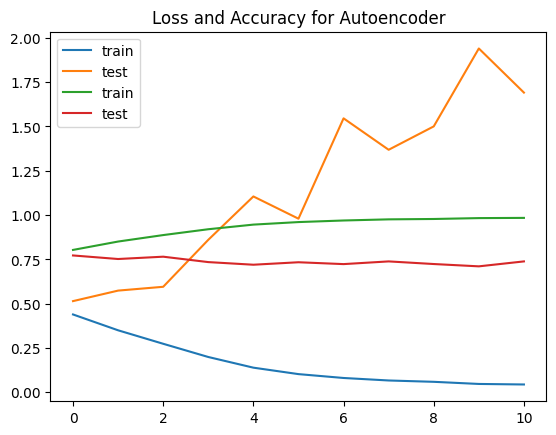

In [29]:
import matplotlib.pyplot as plt

# Plot Loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Loss and Accuracy for Autoencoder')
plt.legend()
plt.savefig('loss_and_accuracy_for_ae.png')  # Save the figure before plt.show()
plt.show()
plt.close()


In [30]:
# save the encoder only
encoder.save('ae_encoder.h5')

### Visual inspection of the reconsructed images vs the real ones

1/1 [==============================] - 0s 203ms/step


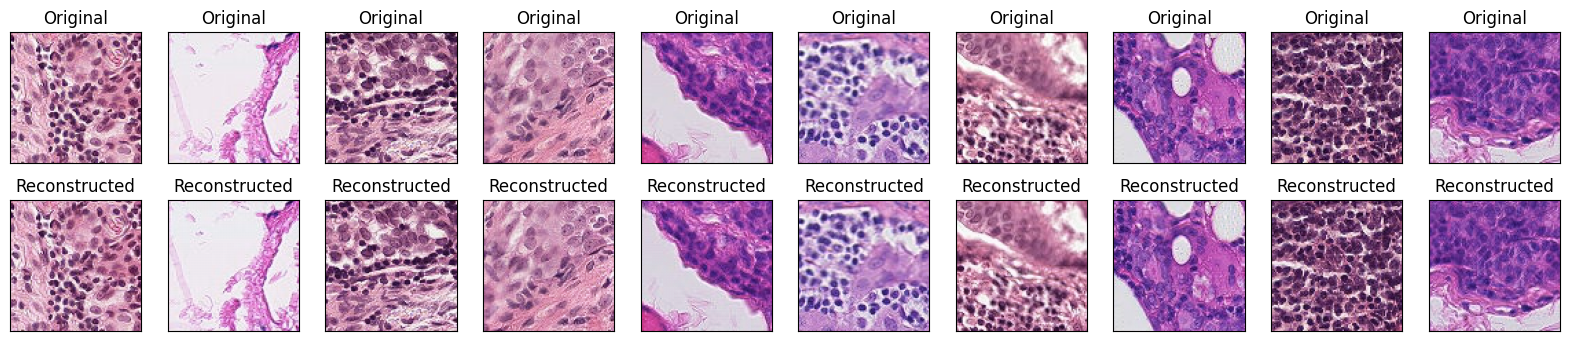

In [14]:
# Take one batch of images from the dataset
for original_images, _ in autoencoder_train_dataset.take(1):
    break

# Get reconstructed images from the autoencoder
reconstructed_images = autoencoder.predict(original_images)

# Define how many images you want to display
n = 10  # for example, display 10 images

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("images_compare.png")
plt.show()
plt.close()

### Compress the data using the trained encoder

In [15]:
# load the model from file
encoder = tf.keras.models.load_model('ae_encoder.h5')

# Print the encoder summary
print(encoder.summary())


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0   

In [16]:
# preprocess for cnn

In [17]:
num_classes = 2
batch_size = 32

def preprocess_encode_and_label(sample):
    # Preprocess the image
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    image = tf.image.resize(image, [96, 96])

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Encode the image using the trained encoder
    encoded_image = encoder(image, training=False)

    # Remove the batch dimension
    encoded_image = tf.squeeze(encoded_image, 0)

    # One-hot encode the label
    label = tf.one_hot(sample['label'], num_classes, dtype=tf.float32)

    return encoded_image, label

# Apply the function to your datasets
encoded_classifier_train_dataset = ds1.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_val_dataset = ds2.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_test_dataset = ds3.map(preprocess_encode_and_label).batch(batch_size)


In [18]:
# Print the structure and shapes of the dataset elements
print('Element structure:', encoded_classifier_train_dataset.element_spec)

# To inspect the shape of the first batch of data
for encoded_images, labels in encoded_classifier_train_dataset.take(1):
    print('Shape of encoded images:', encoded_images.shape)
    print('Shape of labels:', labels.shape)


Element structure: (TensorSpec(shape=(None, 48, 48, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Shape of encoded images: (32, 48, 48, 32)
Shape of labels: (32, 2)


In [19]:
#So, when working within a tf.data.Dataset pipeline, it's more efficient and appropriate to call the model directly, 
#as in encoder(image, training=False), which is graph-compatible and optimized for performance within the TensorFlow ecosystem.

### CNN

In [20]:
encoded_shape = (48,48,32) # shape of the output of the encoder

# Create a new CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_model=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # early stopping

# Print the summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,189,090
Trainable params: 1,189,090
Non-trainable params: 0
______________________________________________

In [21]:
# Train the model
epochs_cnn = 55 #---------------------------------------------

history = cnn_model.fit(encoded_classifier_train_dataset, 
              validation_data=encoded_classifier_val_dataset,
              callbacks=[callback_model],
              epochs=epochs_cnn)

Epoch 1/55
2458/2458 [==============================] - 286s 116ms/step - loss: 0.4390 - accuracy: 0.8032 - val_loss: 0.5143 - val_accuracy: 0.7720
Epoch 2/55
2458/2458 [==============================] - 328s 133ms/step - loss: 0.3496 - accuracy: 0.8505 - val_loss: 0.5736 - val_accuracy: 0.7520
Epoch 3/55
2458/2458 [==============================] - 333s 135ms/step - loss: 0.2735 - accuracy: 0.8870 - val_loss: 0.5952 - val_accuracy: 0.7650
Epoch 4/55
2458/2458 [==============================] - 327s 133ms/step - loss: 0.1989 - accuracy: 0.9200 - val_loss: 0.8603 - val_accuracy: 0.7345
Epoch 5/55
2458/2458 [==============================] - 330s 134ms/step - loss: 0.1387 - accuracy: 0.9461 - val_loss: 1.1051 - val_accuracy: 0.7197
Epoch 6/55
2458/2458 [==============================] - 329s 134ms/step - loss: 0.1023 - accuracy: 0.9604 - val_loss: 0.9796 - val_accuracy: 0.7337
Epoch 7/55
2458/2458 [==============================] - 330s 134ms/step - loss: 0.0805 - accuracy: 0.9694 - val_

In [22]:
cnn_model.save('my_ae_model_p10.h5')

# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_df.to_csv('history_p10.csv')


In [23]:
#cnn_model = tf.keras.models.load_model('my_ae_model.h5')

In [24]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,189,090
Trainable params: 1,189,090
Non-trainable params: 0
______________________________________________

In [25]:
predictions = cnn_model.predict(encoded_classifier_test_dataset)

predictions = np.argmax(predictions, axis=1)

predictions_pd = pd.DataFrame({
    'Id': list(range(len(predictions))),
    'Predicted': predictions.reshape(-1,),
})

predictions_pd.to_csv('ae_predictions_p10.csv', index=False)

72/72 [==============================] - 9s 127ms/step


In [26]:
# Assuming the encoded_test_dataset is already batched and prefetched
true_labels = []
for images, labels in encoded_classifier_test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Convert the true labels to a numpy array
true_labels = np.array(true_labels)

# If true_labels is one-hot encoded, convert it to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate predictions
predictions = cnn_model.predict(encoded_classifier_test_dataset)

# If predictions are probabilities, use argmax to get predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == true_labels)
my_string = f"Accuracy: {accuracy * 100:.2f}%"
print(my_string)


72/72 [==============================] - 10s 134ms/step
Accuracy: 77.68%


In [27]:
# Open the file in write mode ('w') and write the string to it
with open("ae_accuracy_p10.csv", 'w') as file:
    file.write(my_string)